# Coherency and fooof

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
import scipy.signal
from fooof import FOOOF

## Load Litvak Voxels

In [3]:
#################
# read the data #
#################
f_on_data = '../../data/raw/rest/subj1/on/subj1_on_R7.mat'
f_off_data = '../../data/raw/rest/subj1/off/subj1_off_R7.mat'

on_data = scipy.io.loadmat(f_on_data)['data'][0,0][1][0,0]
on_labels = [i[0][0] for i in scipy.io.loadmat(f_on_data)['data'][0,0][0]]
on_t = scipy.io.loadmat(f_on_data)['data'][0,0][2][0,0][0]

off_data = scipy.io.loadmat(f_off_data)['data'][0,0][1][0,0]
off_labels = [i[0][0] for i in scipy.io.loadmat(f_off_data)['data'][0,0][0]]
off_t = scipy.io.loadmat(f_off_data)['data'][0,0][2][0,0][0]

if np.allclose(np.diff(on_t), np.diff(on_t)[0]):
    on_d = np.diff(on_t)[0]
    on_s_rate = 1./on_d
else:
    raise ValueError('Signal must be evenly sampled')

if np.allclose(np.diff(off_t), np.diff(off_t)[0]):
    off_d = np.diff(off_t)[0]
    off_s_rate = 1./off_d
else:
    raise ValueError('Signal must be evenly sampled')

if not on_labels == off_labels:
    raise ValueError('channel labels must be equal during on and off')

In [4]:
del on_labels[-1] # last entry is event marker

# Calc power spectra using Welch's method

### numbers per segment: 2 times sample rate -> compromise between loss of information and smoothness

In [8]:
n_elecs = 9
on_f, on_csd = scipy.signal.welch(on_data[0], fs=on_s_rate, nperseg=2*on_s_rate, average="median")
on_csds = np.zeros([n_elecs, on_csd.shape[0]])
off_csds = np.zeros([n_elecs, on_csd.shape[0]])

for i in range(n_elecs):
    on_f, on_csds[i] = scipy.signal.welch(on_data[i], fs=on_s_rate, nperseg=2*on_s_rate, average="median")
    off_f, off_csds[i] = scipy.signal.welch(off_data[i], fs=on_s_rate, nperseg=2*on_s_rate, average="median")
 

# Test different fooof Parameters on one Cortex and one STN Spectrum

### Defaults:

- peak_width_limits=(0.5, 12.0)
- max_n_peaks=inf
- min_peak_height=0.0
- peak_threshold=2.0
- aperiodic_mode='fixed'
- verbose=True

##### According to fooof tutorial, default settings likely cause overfitting

# I choose:

- freq_range = [2, 45] -> below 2, 1 Hz Filter causes artefact, above 2, aperiodic component is bad
- peak_width_limits=(2, 10) -> lower bound: below 2 noise gets fitted as peak, above 3 theta STN peak is not fitted
- max_n_peaks=3 -> I don't expect more than 3 peaks in the range 2Hz to 45 Hz

#### Kept at default:
- min_peak_height=0 -> in absolute values of data. Inappropriate to change because of different LFP-MEG power scales
- peak_threshold=2.0 -> seems reasonable
- aperiodic_mode='fixed' -> I am interested in the low frequency range up to 50 Hz -> no knee fitting needed
- verbose=True -> I want information on fiting results

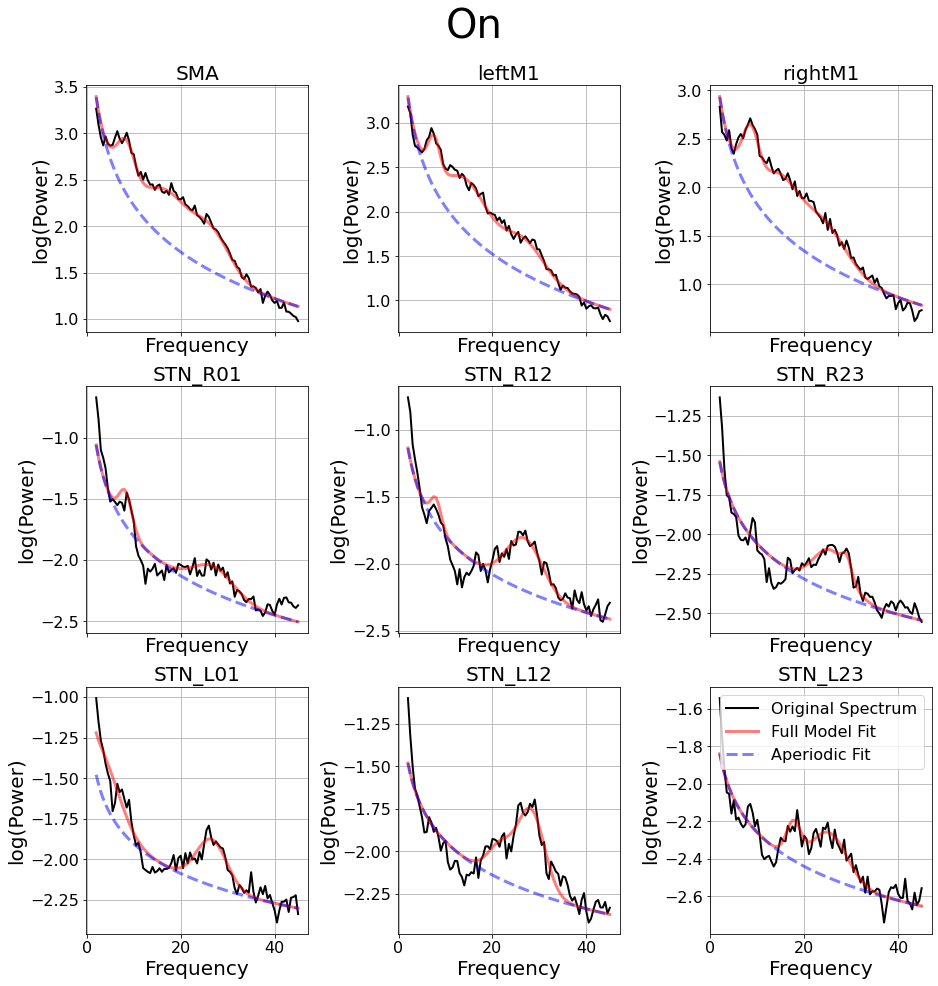

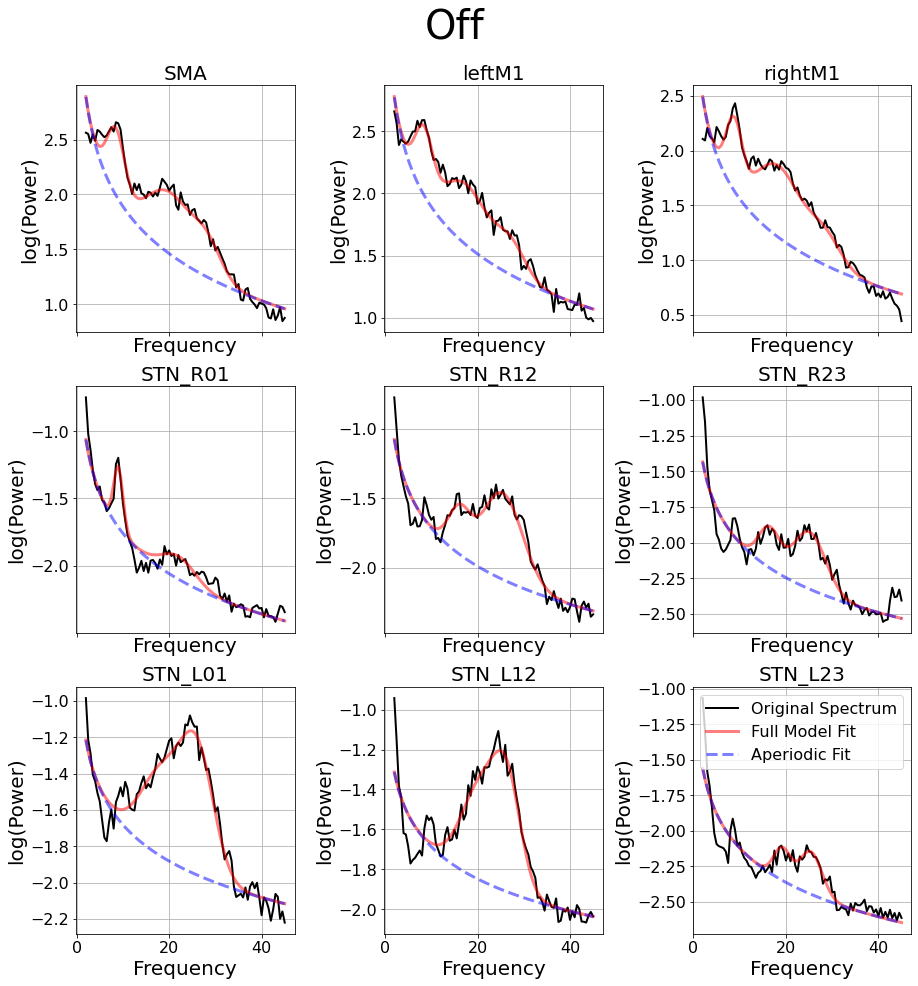

In [66]:
freq_range = [2, 45]

fm = FOOOF(peak_width_limits=(2, 10), max_n_peaks=3, min_peak_height=0, peak_threshold=2, aperiodic_mode="fixed", verbose=True)

fig, ax = plt.subplots(3, 3, figsize=(13, 13), sharex=True, sharey=False)
ax = ax.flatten()
for i in range(9):
    fm.fit(on_f, np.abs(on_csds[i, :]), freq_range)
    fm.plot(ax=ax[i])
   # fm.print_results()
    ax[i].set_title(on_labels[i], fontsize=20)
    if i < 8:
        ax[i].get_legend().remove()

plt.suptitle("On", fontsize=40, position=(0.5, 1.05))
plt.tight_layout()
#plt.savefig('../../plots/fooof_spectra_on.pdf', bbox_inches="tight")

fig, ax = plt.subplots(3, 3, figsize=(13, 13), sharex=True, sharey=False)
ax = ax.flatten()
for i in range(9):
    fm.fit(off_f, np.abs(off_csds[i, :]), freq_range)
    fm.plot(ax=ax[i])
   # fm.print_results()
    ax[i].set_title(off_labels[i], fontsize=20)
    if i < 8:
        ax[i].get_legend().remove()

plt.suptitle("Off", fontsize=40, position=(0.5, 1.05))
plt.tight_layout()
#plt.savefig('../../plots/fooof_spectra_off.pdf', bbox_inches="tight")

# Load Data with removed 50 Hz notches

# Repeat for large spectrum in range 2Hz to 150Hz

- freq_range = [2, 150] -> below 2, 1 Hz Filter causes artefact, need aperiodic component in range 20-100, for better "knee" fitting I choose 150 Hz as upper limit
- peak_width_limits=(2, 10) -> lower bound: below 2 noise gets fitted as peak, above 3 theta STN peak is not fitted
- max_n_peaks=5 -> I don't expect more than 5 peaks in the range 2Hz to 150 Hz
- aperiodic_mode='knee' -> Needed for larger frequency ranges

#### Kept at default:
- min_peak_height=0 -> in absolute values of data. Inappropriate to change because of different LFP-MEG power scales
- peak_threshold=2.0 -> seems reasonable
- verbose=True -> I want information on fiting results

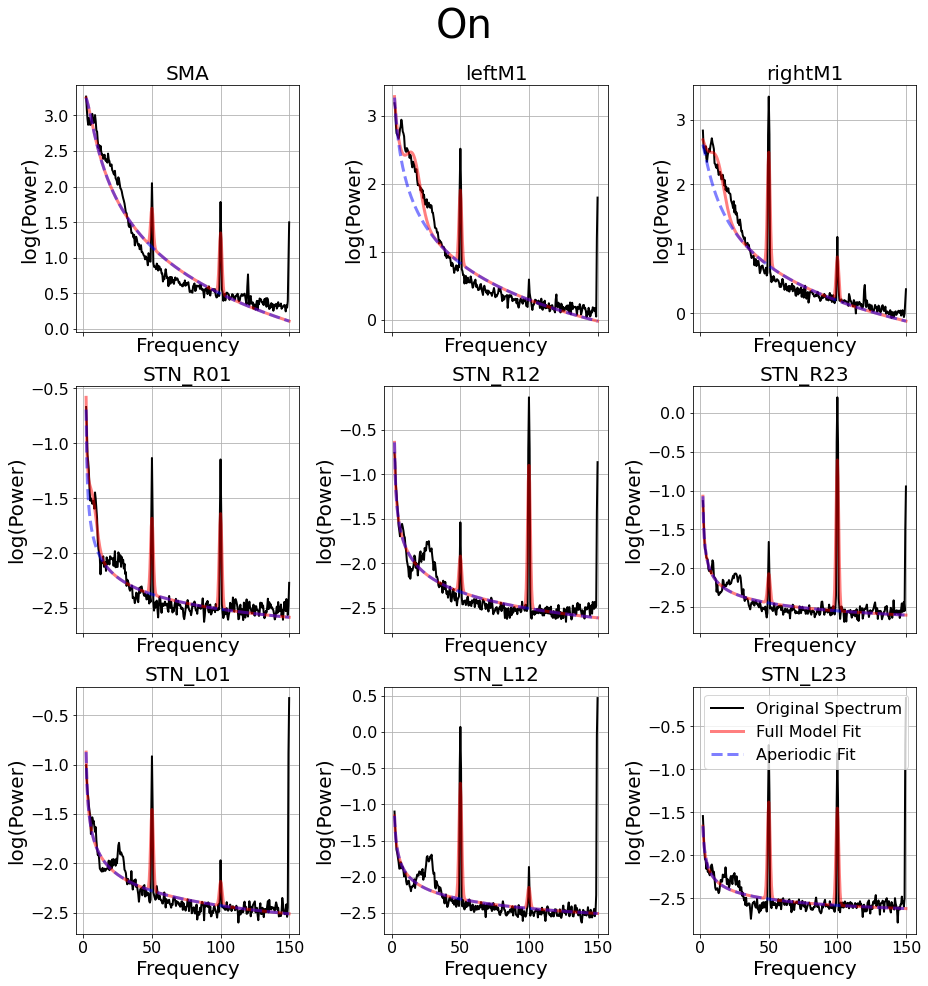

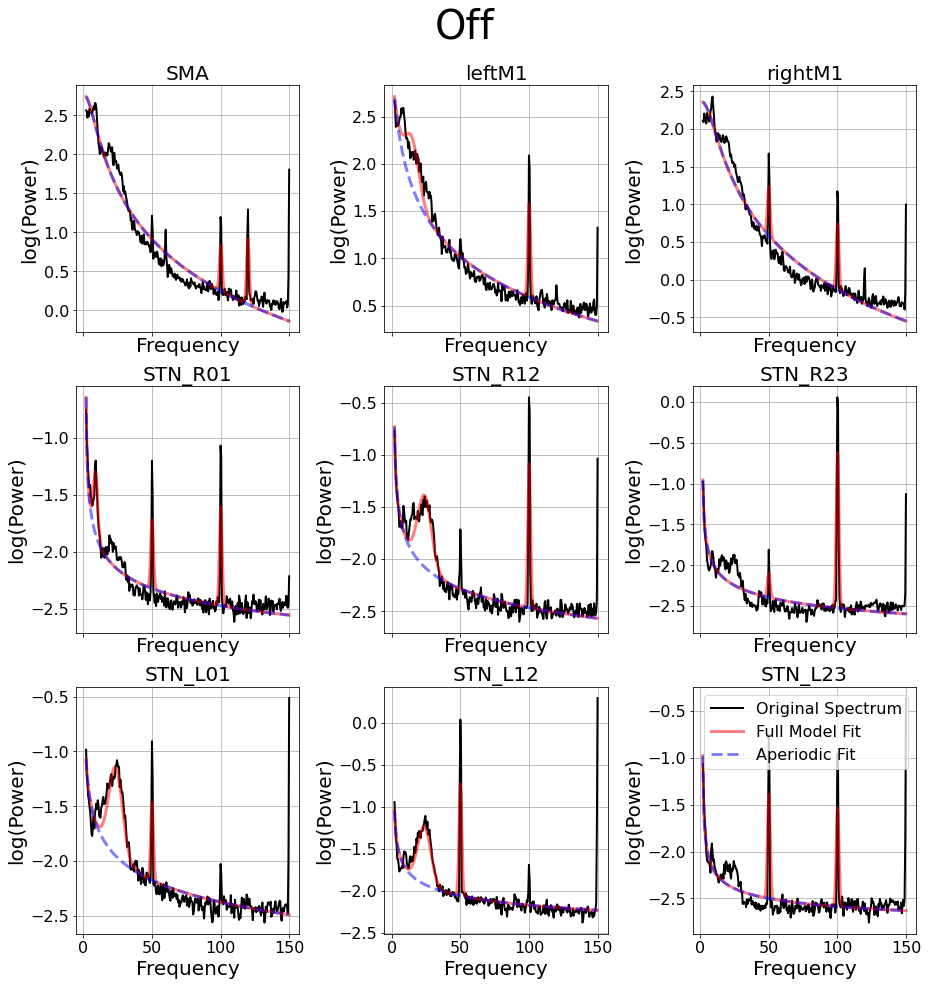

In [68]:
freq_range = [2, 150]

fm = FOOOF(peak_width_limits=(2, 10), max_n_peaks=5, min_peak_height=0, peak_threshold=2, aperiodic_mode="knee", verbose=True)

fig, ax = plt.subplots(3, 3, figsize=(13, 13), sharex=True, sharey=False)
ax = ax.flatten()
for i in range(9):
    fm.fit(on_f, np.abs(on_csds[i, :]), freq_range)
    fm.plot(ax=ax[i])
   # fm.print_results()
    ax[i].set_title(on_labels[i], fontsize=20)
    if i < 8:
        ax[i].get_legend().remove()

plt.suptitle("On", fontsize=40, position=(0.5, 1.05))
plt.tight_layout()
#plt.savefig('../../plots/fooof_spectra_on.pdf', bbox_inches="tight")

fig, ax = plt.subplots(3, 3, figsize=(13, 13), sharex=True, sharey=False)
ax = ax.flatten()
for i in range(9):
    fm.fit(off_f, np.abs(off_csds[i, :]), freq_range)
    fm.plot(ax=ax[i])
   # fm.print_results()
    ax[i].set_title(off_labels[i], fontsize=20)
    if i < 8:
        ax[i].get_legend().remove()

plt.suptitle("Off", fontsize=40, position=(0.5, 1.05))
plt.tight_layout()
#plt.savefig('../../plots/fooof_spectra_off.pdf', bbox_inches="tight")